# Unsupervised Learning Trading Strategy

- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [1]:
!pip install pandas
!pip install pandas_ta
!pip install matplotlib
!pip install statsmodels
!pip install pandas_datareader
!pip install datetime
!pip install yfinance
!pip install scikit-learn
!pip install PyPortfolioOpt

# 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

# Note that these dates may imply survivorship bias of stocks
end_date = dt.date.today().strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

df = df.stack()
                                    
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2016-02-01 A        35.322849   37.689999   37.950001   37.000000   37.369999   
           AAL      37.633324   39.380001   39.939999   38.630001   39.000000   
           AAPL     21.947298   24.107500   24.177500   23.850000   24.117500   
           ABBV     38.535049   54.389999   54.880001   52.509998   54.160000   
           ABT      33.148434   38.450001   38.709999   36.169998   36.169998   
...                       ...         ...         ...         ...         ...   
2024-01-26 YUM     129.089996  129.089996  130.690002  128.669998  129.919998   
           ZBH     121.690002  121.690002  123.110001  121.570000  122.839996   
           ZBRA    252.169998  252.169998  258.420013  251.619995  256.980011   
           ZION     44.020000   44.020000   44.860001   43.959999   44.500000   
           ZTS     191.520004  191.520004  192.880005  188.970001  189.210007   

                        volume  
date       ticker               
2016-02-01 A         2666200.0  
           AAL      12023500.0  
           AAPL    163774000.0  
           ABBV     11693300.0  
           ABT      14252500.0  
...                        ...  
2024-01-26 YUM       1157000.0  
           ZBH        982800.0  
           ZBRA       268300.0  
           ZION      1504900.0  
           ZTS       1840200.0  

[994385 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.
- Garman-Klass Volatility
- Relative Strength Index (RSI)
- Bollinger Bands
- Average True Range (ATR)
- Moving Average Convergence/Divergence (MACD)
- Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}


The Garman-Klass volatility is a method for estimating the volatility of financial asset return.  
The formula is based on the high, low, open, and close prices of a financial asset.  
Used to measure the level of price fluctuations or volatility in the market.

In [2]:
df['garman_klass_volatility'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2) - 1)*(np.log(df['adj close'])-np.log(df['open']))**2

# RSI https://www.investopedia.com/terms/r/rsi.asp - momentum indicator
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Bollinger Band https://www.investopedia.com/terms/b/bollingerbands.asp - compute SMA, lower middle upper bound
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# ATR https://www.investopedia.com/terms/a/atr.asp
def compute_atr(stock_data):
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'], 
        close=stock_data['close'], 
        length=14
    )
    # normalize atr value
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# MACD https://www.investopedia.com/terms/m/macd.asp
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Dollar Volume https://www.investopedia.com/terms/d/dollar-volume-liquidity.asp
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6 # assumption: million of shares created each day

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-02-01 A        35.322849   37.689999   37.950001   37.000000   37.369999   
           AAL      37.633324   39.380001   39.939999   38.630001   39.000000   
           AAPL     21.947298   24.107500   24.177500   23.850000   24.117500   
           ABBV     38.535049   54.389999   54.880001   52.509998   54.160000   
           ABT      33.148434   38.450001   38.709999   36.169998   36.169998   
...                       ...         ...         ...         ...         ...   
2024-01-26 YUM     129.089996  129.089996  130.690002  128.669998  129.919998   
           ZBH     121.690002  121.690002  123.110001  121.570000  122.839996   
           ZBRA    252.169998  252.169998  258.420013  251.619995  256.980011   
           ZION     44.020000   44.020000   44.860001   43.959999   44.500000   
           ZTS     191.520004  191.520004  192.880005  188.970001  189.210007   

                        volume  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                              
2016-02-01 A         2666200.0                -0.000905        NaN       NaN   
           AAL      12023500.0                 0.000065        NaN       NaN   
           AAPL    163774000.0                -0.003342        NaN       NaN   
           ABBV     11693300.0                -0.043780        NaN       NaN   
           ABT      14252500.0                -0.000637        NaN       NaN   
...                        ...                      ...        ...       ...   
2024-01-26 YUM       1157000.0                 0.000105  50.708962  4.856013   
           ZBH        982800.0                 0.000045  56.739863  4.794179   
           ZBRA       268300.0                 0.000218  51.191561  5.479828   
           ZION      1504900.0                 0.000160  57.948030  3.728311   
           ZTS       1840200.0                 0.000153  52.795286  5.230000   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-02-01 A            NaN       NaN       NaN       NaN      94.177781  
           AAL          NaN       NaN       NaN       NaN     452.484267  
           AAPL         NaN       NaN       NaN       NaN    3594.396791  
           ABBV         NaN       NaN       NaN       NaN     450.601894  
           ABT          NaN       NaN       NaN       NaN     472.448051  
...                     ...       ...       ...       ...            ...  
2024-01-26 YUM     4.872770  4.889527 -0.004229  0.165985     149.357126  
           ZBH     4.811249  4.828319 -0.667781  0.368864     119.596934  
           ZBRA    5.545973  5.612118  0.053994 -0.021176      67.657211  
           ZION    3.786146  3.843982  0.453255  0.539469      66.245699  
           ZTS     5.267848  5.305696  0.707087 -0.325591     352.435112  

[994385 rows x 14 columns]

# 3. Aggregate to monthly level & filter top 150 most liquid stocks for each month
- Why top 150? To reduce waiting training time and expriment with features and strategies, we convert business-daily data to month-end frequency.

In [3]:
# The liquidity of a stock is a reference to how easy or difficult it would be for a market participant 
# to sell the stock without impacting the price.

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat(
    [df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')],
    axis=1
).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-03-31 A           62.013608   37.347183 -1.143771  3.665222  3.598942   
           AAL        298.909269   39.297947  0.135617  3.753792  3.680381   
           AAPL      3235.327918   24.940538 -1.106745  3.263829  3.168778   
           ABBV       256.185611   40.469238 -0.969713  3.735461  3.690339   
           ABT        229.241198   36.062393 -1.147339  3.619339  3.532533   
...                          ...         ...       ...       ...       ...   
2024-01-31 YUM        196.809561  129.089996 -0.004229  4.889527  4.856013   
           ZBH        204.029004  121.690002 -0.667781  4.828319  4.794179   
           ZBRA        99.053216  252.169998  0.053994  5.612118  5.479828   
           ZION       109.331953   44.020000  0.453255  3.843982  3.728311   
           ZTS        363.109587  191.520004  0.707087  5.305696  5.230000   

                     bb_mid  garman_klass_volatility      macd        rsi  
date       ticker                                                          
2016-03-31 A       3.632082                -0.001771  0.170747  57.927679  
           AAL     3.717086                -0.001005  0.656510  50.169533  
           AAPL    3.216304                -0.003453  0.032924  71.614603  
           ABBV    3.712900                -0.045347 -0.028475  55.286067  
           ABT     3.575936                -0.007947  0.348929  68.511702  
...                     ...                      ...       ...        ...  
2024-01-31 YUM     4.872770                 0.000105  0.165985  50.708962  
           ZBH     4.811249                 0.000045  0.368864  56.739863  
           ZBRA    5.545973                 0.000218 -0.021176  51.191561  
           ZION    3.786146                 0.000160  0.539469  57.948030  
           ZTS     5.267848                 0.000153 -0.325591  52.795286  

[46973 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

# filter and get top 150 dollar volume only
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-02-28 AAL      44.898853  0.233546  3.864723  3.767394  3.816059   
           AAPL     32.010574 -1.184247  3.528788  3.405187  3.466988   
           ABBV     45.488468 -1.520090  3.847692  3.810368  3.829030   
           ABT      39.848412 -1.270373  3.734055  3.624358  3.679207   
           ACN     109.569901 -1.104562  4.731512  4.614227  4.672869   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    430.170013  0.784424  6.103808  6.005536  6.054672   
           VZ       42.400002  0.080403  3.772190  3.621979  3.697084   
           WFC      50.320000 -0.539804  3.952834  3.862753  3.907793   
           WMT     164.270004 -0.074320  5.111174  5.058206  5.084690   
           XOM     103.000000  0.182394  4.656185  4.570105  4.613145   

                   garman_klass_volatility      macd        rsi  
date       ticker                                                
2017-02-28 AAL                   -0.000264  0.086653  50.168971  
           AAPL                  -0.001782  0.184280  84.345176  
           ABBV                  -0.037405 -0.155067  53.680469  
           ABT                   -0.006505  0.663215  71.877132  
           ACN                   -0.004939  0.176823  63.223004  
...                                    ...       ...        ...  
2024-01-31 VRTX                   0.000043  2.545281  64.519320  
           VZ                     0.000040  2.475714  70.186636  
           WFC                    0.000071  0.596884  63.682813  
           WMT                    0.000034  0.916126  60.845739  
           XOM                    0.000132 -0.441742  55.632470  

[12516 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [5]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    
    # time lags in months
    lags = [1, 2, 3, 6, 9, 12]
    
    # calculates the percentage change of the 'adj close' column over a lag period. 
    # The pct_change function computes the percentage change between the current 
    # element and the element at the lagged position.
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag).pipe(lambda x: x.clip(
                                   lower=x.quantile(outlier_cutoff),
                                   upper=x.quantile(1-outlier_cutoff)
                               ))
                               .add(1)
                               .pow(1/lag)  #to account for compounding effects over the given lag period.
                               .sub(1))
        
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna();

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-02-28 AAL      52.977325  1.361048  4.015218  3.875603  3.945411   
           AAPL     42.279884 -0.787958  3.795134  3.617069  3.706102   
           ABBV     88.056595  1.939132  4.539666  4.420361  4.480013   
           ABT      54.474918 -0.601547  4.051457  3.947487  3.999472   
           ACN     146.918533 -0.512644  5.030859  4.932437  4.981648   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    430.170013  0.784424  6.103808  6.005536  6.054672   
           VZ       42.400002  0.080403  3.772190  3.621979  3.697084   
           WFC      50.320000 -0.539804  3.952834  3.862753  3.907793   
           WMT     164.270004 -0.074320  5.111174  5.058206  5.084690   
           XOM     103.000000  0.182394  4.656185  4.570105  4.613145   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2018-02-28 AAL                   -0.000118  0.426365  55.685266   0.000632   
           AAPL                  -0.001207 -0.023707  59.836068   0.068185   
           ABBV                  -0.034391  1.168406  56.507202   0.032169   
           ABT                   -0.004361 -0.045574  55.823876  -0.029440   
           ACN                   -0.003895  0.111409  54.875640   0.001929   
...                                    ...       ...        ...        ...   
2024-01-31 VRTX                   0.000043  2.545281  64.519320   0.057214   
           VZ                     0.000040  2.475714  70.186636   0.128932   
           WFC                    0.000071  0.596884  63.682813   0.022349   
           WMT                    0.000034  0.916126  60.845739   0.041992   
           XOM                    0.000132 -0.441742  55.632470   0.030206   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-02-28 AAL      0.022092   0.024888   0.033351   0.013426    0.013883  
           AAPL     0.028019   0.013390   0.015155   0.018521    0.023458  
           ABBV     0.098315   0.063744   0.076940   0.065862    0.050452  
           ABT      0.030620   0.024517   0.030254   0.033180    0.026397  
           ACN      0.025541   0.028460   0.036957   0.030116    0.024744  
...                      ...        ...        ...        ...         ...  
2024-01-31 VRTX     0.101088   0.059091   0.033823   0.026237    0.024138  
           VZ       0.060583   0.066071   0.043639   0.016077    0.007677  
           WFC      0.062311   0.084792   0.017307   0.029339    0.008523  
           WMT      0.029091   0.002990   0.005761   0.010665    0.012388  
           XOM      0.001265  -0.006045  -0.003838  -0.012469   -0.007089  

[10343 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
- Use the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- Access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10053 rows x 6 columns]

- Filter out stocks with less than 10 months of data

In [7]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10015 rows x 6 columns]

- Calculate Rolling Factor Betas

In [8]:
betas = (factor_data.groupby(level=1,
                             group_keys=False)
            .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                        exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                        window=min(24, x.shape[0]),
                                        min_nobs=len(x.columns) + 1)
        .fit(params_only=True)
        .params
        .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-02-28 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376235 -0.326701 -0.444955  0.318725  0.869058
           VZ      0.444419 -0.663075  0.517885  0.210238 -0.206425
           WFC     1.037897  0.401000  2.011854 -0.363961 -1.477538
           WMT     0.497263  0.081987 -0.731001  0.577486  0.752986
           XOM     0.722590 -0.210772  1.202658  0.229338  0.172209

[10015 rows x 5 columns]

In [13]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# data = (data.join(betas.groupby('ticker').shift()))

# shift one month forward
# ensure that the betas used in any forward-looking analysis, 
# such as predictions or strategy backtesting, are not using information from the future.

# data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# data = data.drop('adj close', axis=1)

# data = data.dropna()

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                           
2018-02-28 AAL     1.361048  4.015218  3.875603  3.945411   
           AAPL   -0.787958  3.795134  3.617069  3.706102   
           ABBV    1.939132  4.539666  4.420361  4.480013   
           ABT    -0.601547  4.051457  3.947487  3.999472   
           ACN    -0.512644  5.030859  4.932437  4.981648   
...                     ...       ...       ...       ...   
2024-01-31 VRTX    0.784424  6.103808  6.005536  6.054672   
           VZ      0.080403  3.772190  3.621979  3.697084   
           WFC    -0.539804  3.952834  3.862753  3.907793   
           WMT    -0.074320  5.111174  5.058206  5.084690   
           XOM     0.182394  4.656185  4.570105  4.613145   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2018-02-28 AAL                   -0.000118  0.426365  55.685266   0.000632   
           AAPL                  -0.001207 -0.023707  59.836068   0.068185   
           ABBV                  -0.034391  1.168406  56.507202   0.032169   
           ABT                   -0.004361 -0.045574  55.823876  -0.029440   
           ACN                   -0.003895  0.111409  54.875640   0.001929   
...                                    ...       ...        ...        ...   
2024-01-31 VRTX                   0.000043  2.545281  64.519320   0.057214   
           VZ                     0.000040  2.475714  70.186636   0.128932   
           WFC                    0.000071  0.596884  63.682813   0.022349   
           WMT                    0.000034  0.916126  60.845739   0.041992   
           XOM                    0.000132 -0.441742  55.632470   0.030206   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-02-28 AAL      0.022092   0.024888   0.033351   0.013426    0.013883   
           AAPL     0.028019   0.013390   0.015155   0.018521    0.023458   
           ABBV     0.098315   0.063744   0.076940   0.065862    0.050452   
           ABT      0.030620   0.024517   0.030254   0.033180    0.026397   
           ACN      0.025541   0.028460   0.036957   0.030116    0.024744   
...                      ...        ...        ...        ...         ...   
2024-01-31 VRTX     0.101088   0.059091   0.033823   0.026237    0.024138   
           VZ       0.060583   0.066071   0.043639   0.016077    0.007677   
           WFC      0.062311   0.084792   0.017307   0.029339    0.008523   
           WMT      0.029091   0.002990   0.005761   0.010665    0.012388   
           XOM      0.001265  -0.006045  -0.003838  -0.012469   -0.007089   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-02-28 AAL     1.243504  1.383284  0.539491  0.265422  0.725411  
           AAPL    1.319781 -0.346321 -0.627258  0.535578  0.606357  
           ABBV    0.465555  0.519803 -0.115578  0.441035  0.293379  
           ABT     0.814906 -0.155963 -0.515119  0.292037  0.993281  
           ACN     1.219179 -0.160238 -0.304196  0.309653  0.182729  
...                     ...       ...       ...       ...       ...  
2024-01-31 VRTX    0.524475  0.002246 -0.905770  0.132113  0.859881  
           VZ      0.483510 -0.362031  0.102756  0.286549  0.438225  
           WFC     1.070708 -0.087783  1.463066 -0.731970 -0.650393  
           WMT     0.605182 -0.440873 -0.313069  0.307061  0.686230  
           XOM     1.132565  0.268721  0.705765 -0.497147  0.613262  

[10155 rows x 18 columns]

## At this point we have to decide on what ML model and approach to use for predictions

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

### K-Means Clustering
- Initialize predefined centrids for each cluster based on your research
- Initially rely on the "k-means++" initialization for data visualization purpose
- Then predefine centroids for each cluster

In [14]:
def plot_clusters(data):
    
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    # RSI (6th index) to be the y-axis indicator
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color= 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color= 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color= 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color= 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

## Strategy: follow stocks momentum using the RSI as main indicator and invest every month in stocks with highest upward momentum

# Apply predefined centroids (centered around RSI)

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [18]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

# 4 clusters is optimal
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0, 
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                           
2018-02-28 AAL     1.361048  4.015218  3.875603  3.945411   
           AAPL   -0.787958  3.795134  3.617069  3.706102   
           ABBV    1.939132  4.539666  4.420361  4.480013   
           ABT    -0.601547  4.051457  3.947487  3.999472   
           ACN    -0.512644  5.030859  4.932437  4.981648   
...                     ...       ...       ...       ...   
2024-01-31 VRTX    0.784424  6.103808  6.005536  6.054672   
           VZ      0.080403  3.772190  3.621979  3.697084   
           WFC    -0.539804  3.952834  3.862753  3.907793   
           WMT    -0.074320  5.111174  5.058206  5.084690   
           XOM     0.182394  4.656185  4.570105  4.613145   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2018-02-28 AAL                   -0.000118  0.426365  55.685266   0.000632   
           AAPL                  -0.001207 -0.023707  59.836068   0.068185   
           ABBV                  -0.034391  1.168406  56.507202   0.032169   
           ABT                   -0.004361 -0.045574  55.823876  -0.029440   
           ACN                   -0.003895  0.111409  54.875640   0.001929   
...                                    ...       ...        ...        ...   
2024-01-31 VRTX                   0.000043  2.545281  64.519320   0.057214   
           VZ                     0.000040  2.475714  70.186636   0.128932   
           WFC                    0.000071  0.596884  63.682813   0.022349   
           WMT                    0.000034  0.916126  60.845739   0.041992   
           XOM                    0.000132 -0.441742  55.632470   0.030206   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-02-28 AAL      0.022092   0.024888   0.033351   0.013426    0.013883   
           AAPL     0.028019   0.013390   0.015155   0.018521    0.023458   
           ABBV     0.098315   0.063744   0.076940   0.065862    0.050452   
           ABT      0.030620   0.024517   0.030254   0.033180    0.026397   
           ACN      0.025541   0.028460   0.036957   0.030116    0.024744   
...                      ...        ...        ...        ...         ...   
2024-01-31 VRTX     0.101088   0.059091   0.033823   0.026237    0.024138   
           VZ       0.060583   0.066071   0.043639   0.016077    0.007677   
           WFC      0.062311   0.084792   0.017307   0.029339    0.008523   
           WMT      0.029091   0.002990   0.005761   0.010665    0.012388   
           XOM      0.001265  -0.006045  -0.003838  -0.012469   -0.007089   

                     Mkt-RF       SMB       HML       RMW       CMA  cluster  
date       ticker                                                             
2018-02-28 AAL     1.243504  1.383284  0.539491  0.265422  0.725411        2  
           AAPL    1.319781 -0.346321 -0.627258  0.535578  0.606357        3  
           ABBV    0.465555  0.519803 -0.115578  0.441035  0.293379        2  
           ABT     0.814906 -0.155963 -0.515119  0.292037  0.993281        2  
           ACN     1.219179 -0.160238 -0.304196  0.309653  0.182729        2  
...                     ...       ...       ...       ...       ...      ...  
2024-01-31 VRTX    0.524475  0.002246 -0.905770  0.132113  0.859881        3  
           VZ      0.483510 -0.362031  0.102756  0.286549  0.438225        3  
           WFC     1.070708 -0.087783  1.463066 -0.731970 -0.650393        3  
           WMT     0.605182 -0.440873 -0.313069  0.307061  0.686230        2  
           XOM     1.132565  0.268721  0.705765 -0.497147  0.613262        2  

[10155 rows x 19 columns]

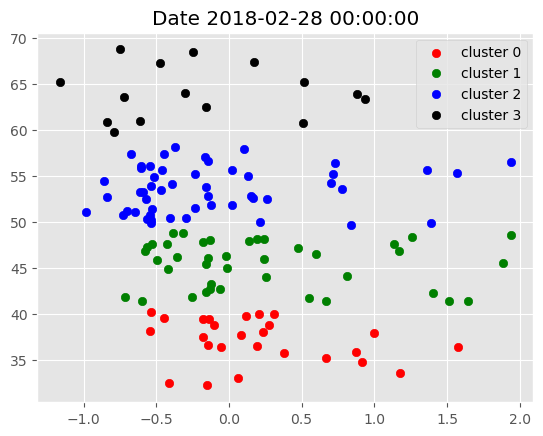

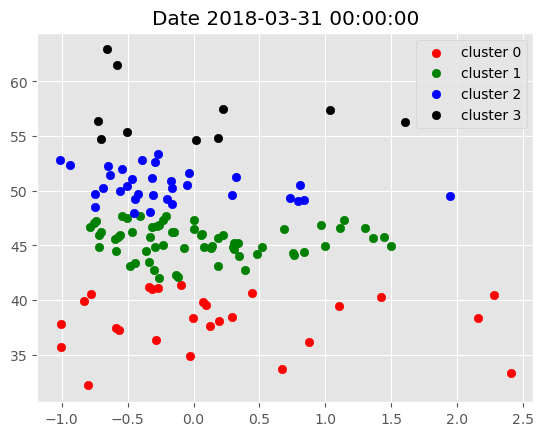

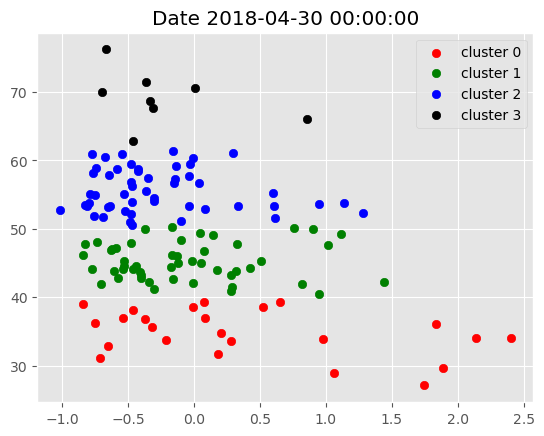

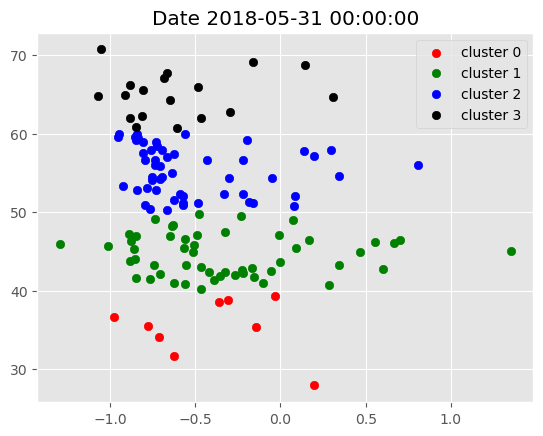

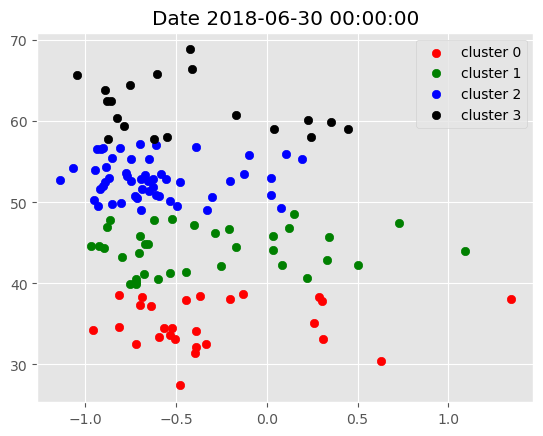

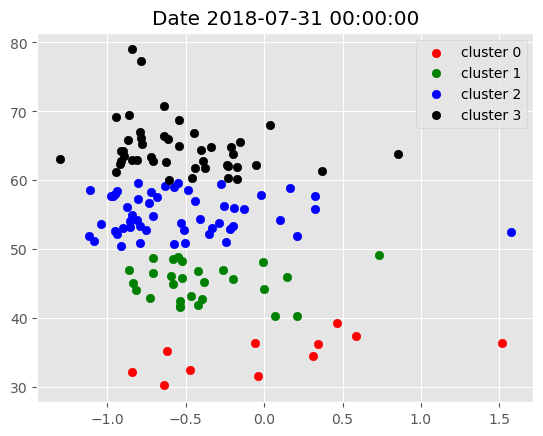

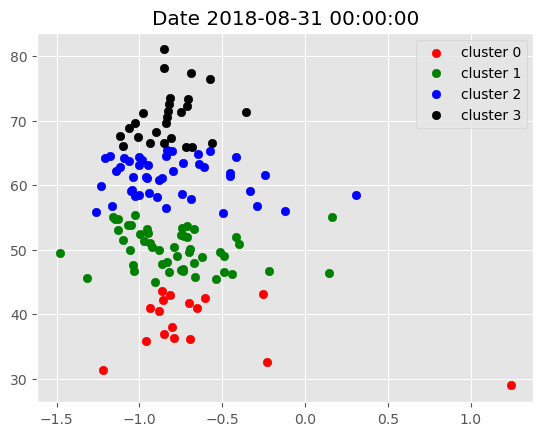

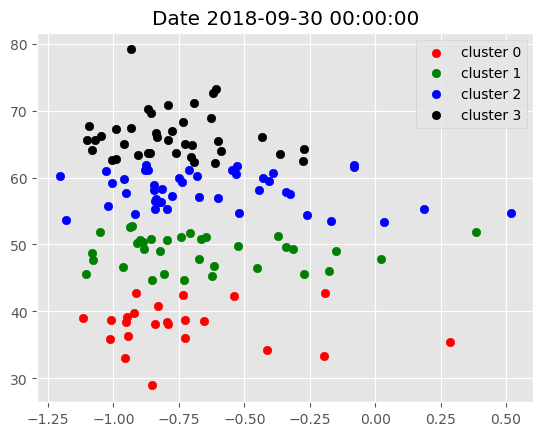

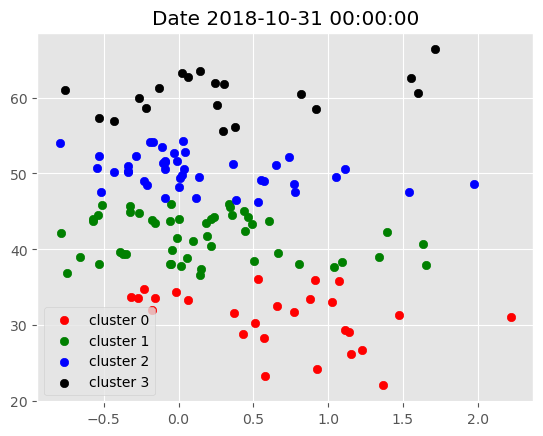

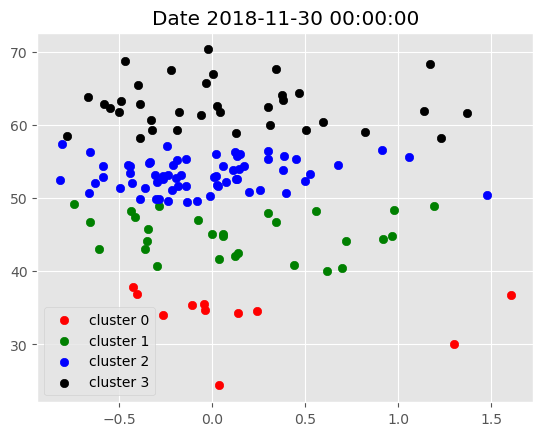

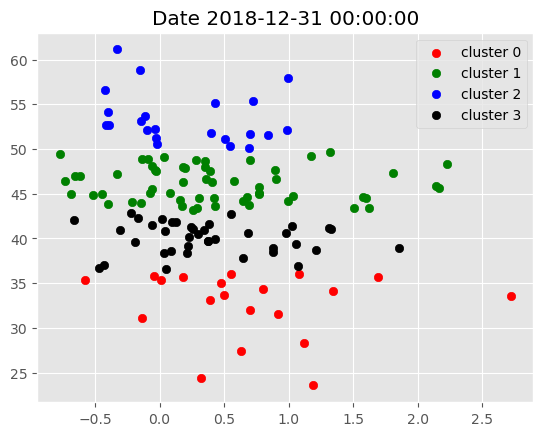

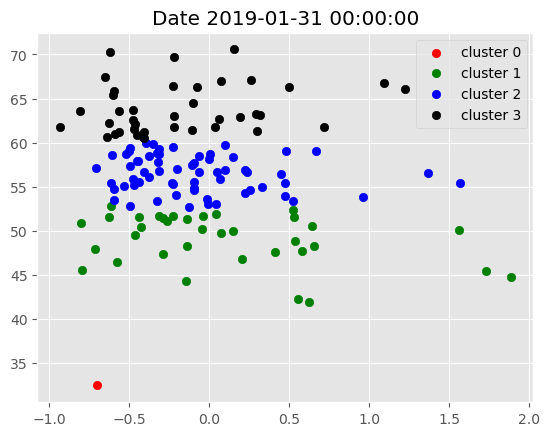

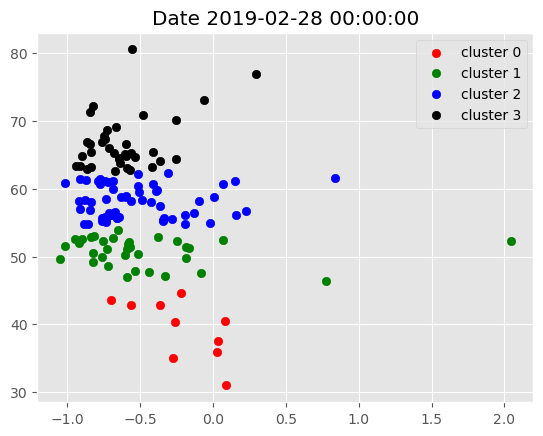

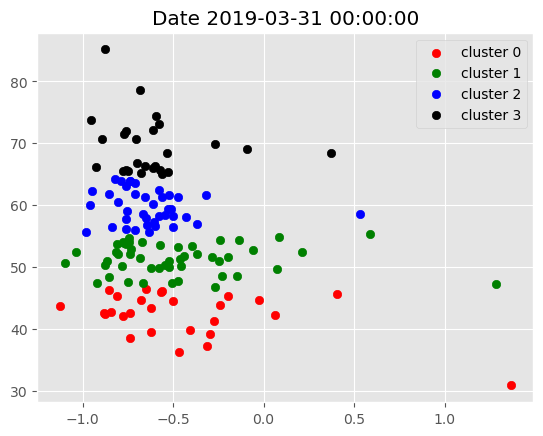

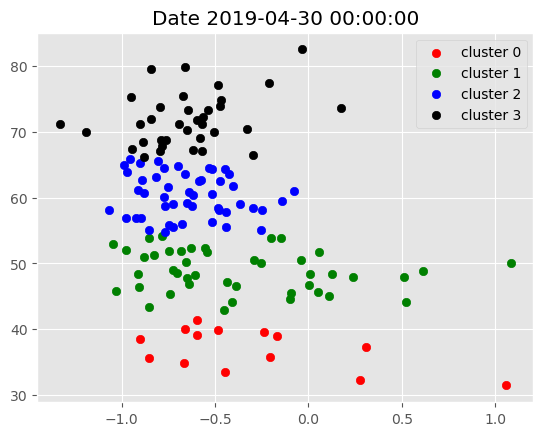

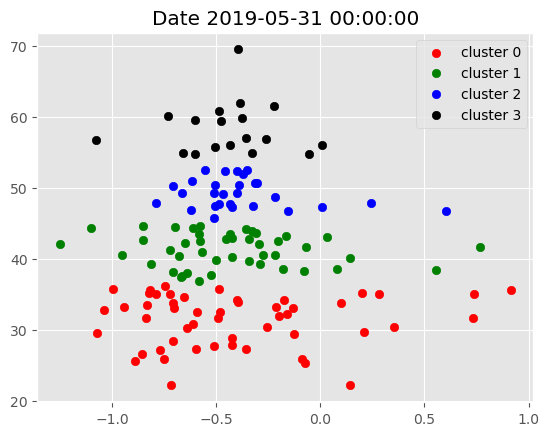

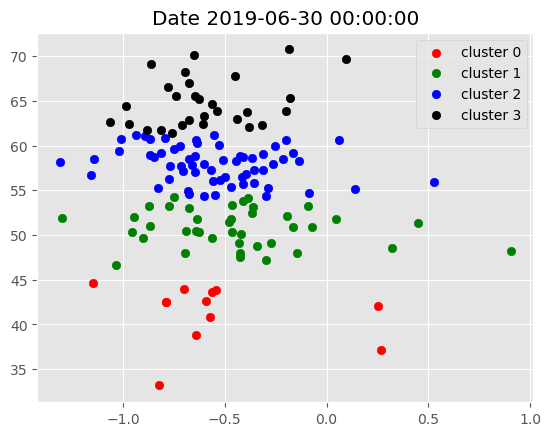

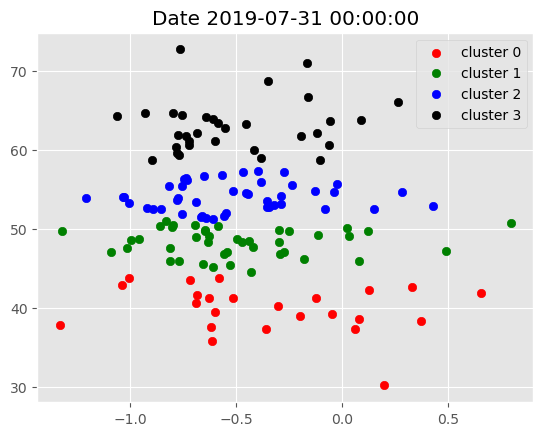

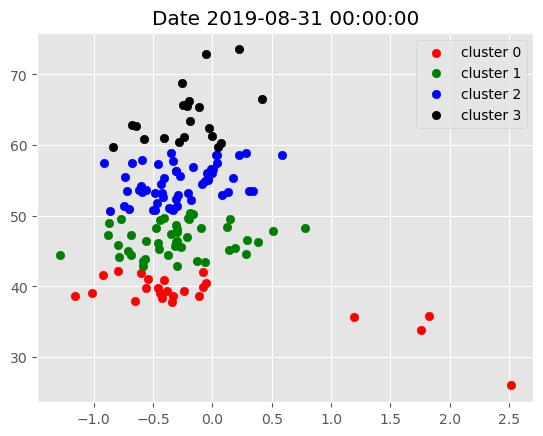

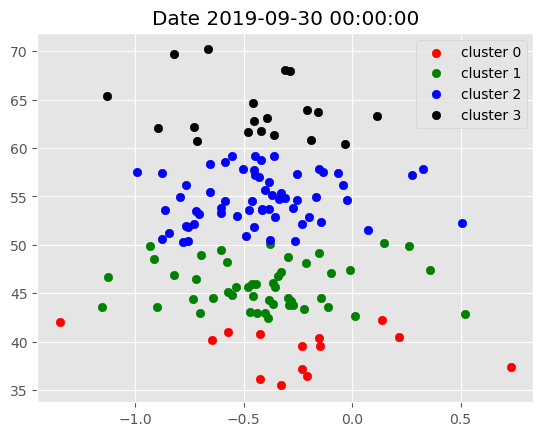

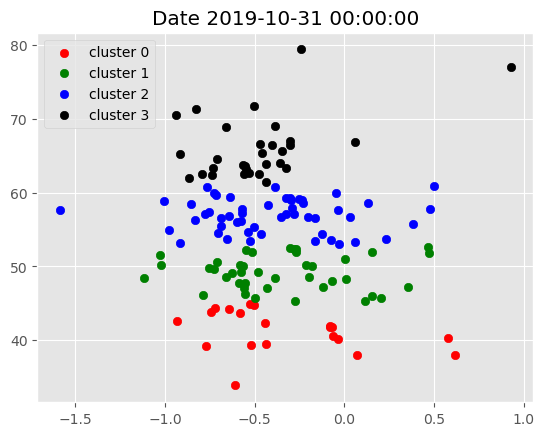

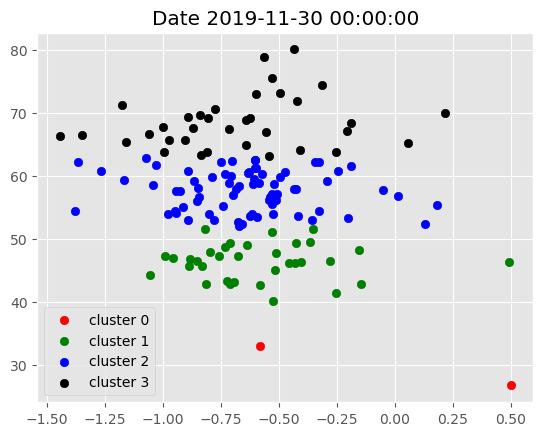

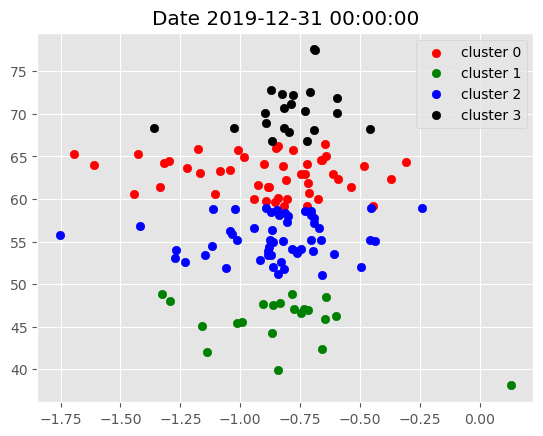

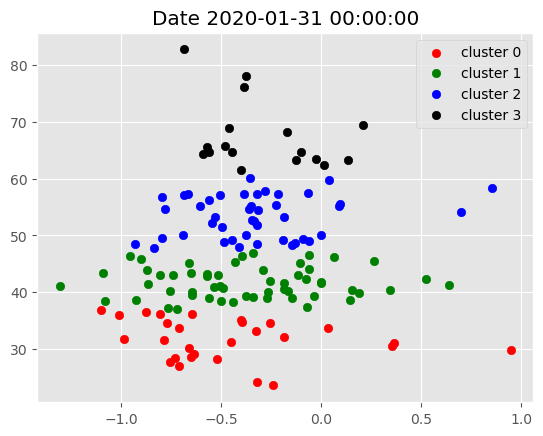

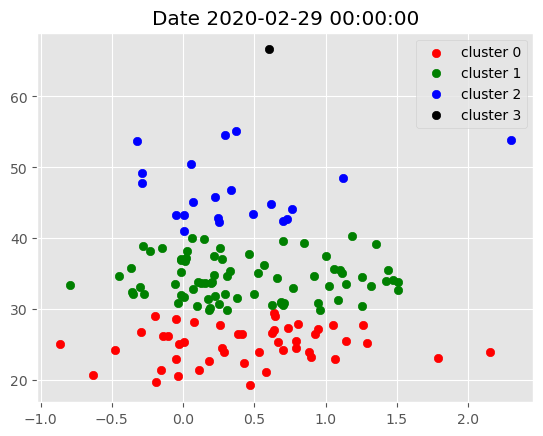

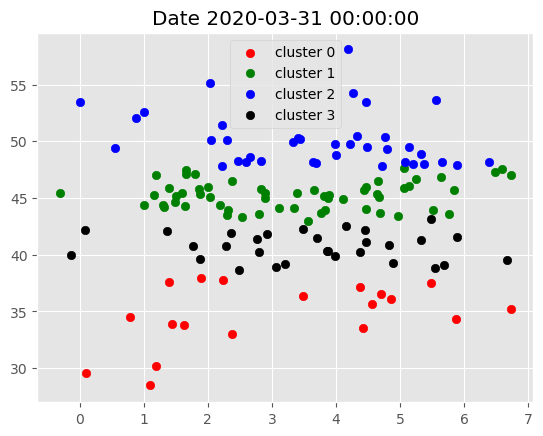

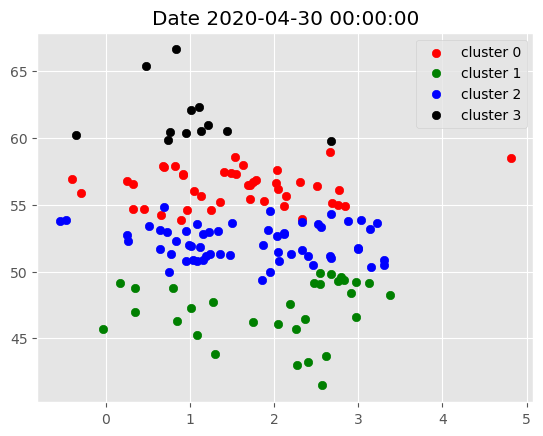

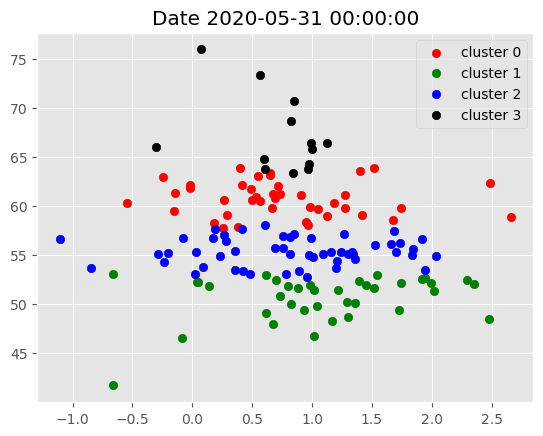

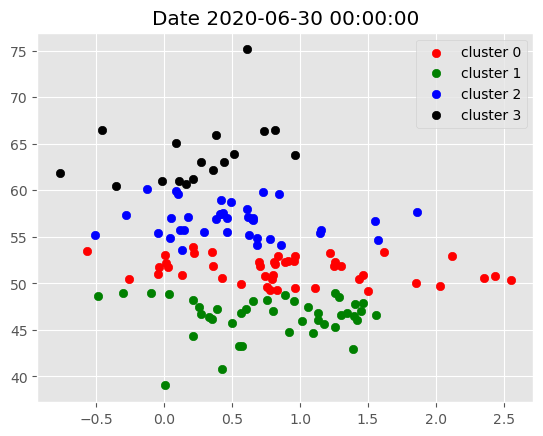

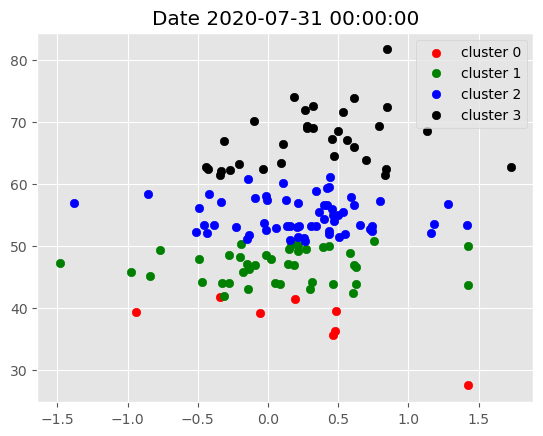

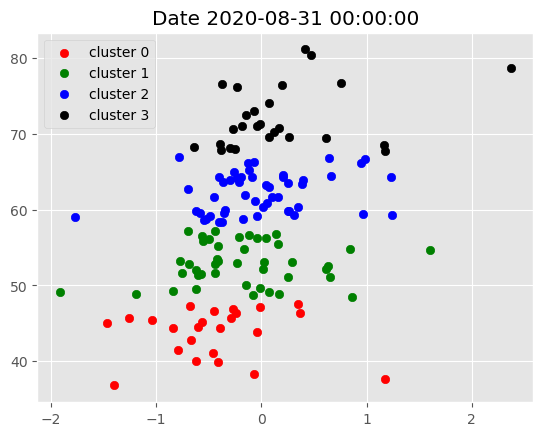

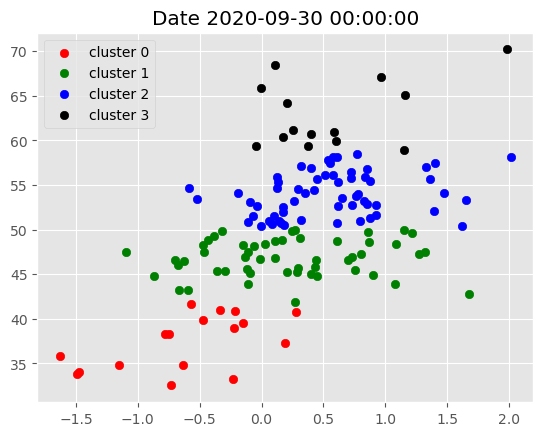

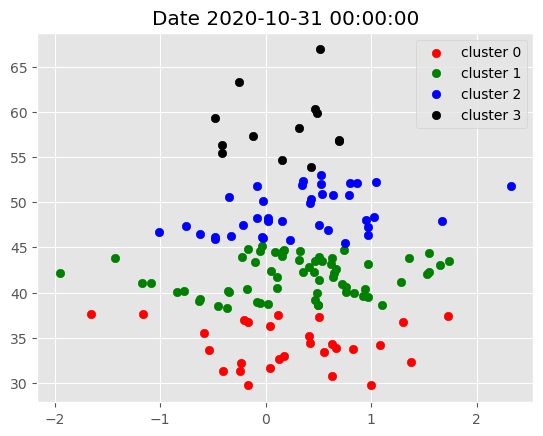

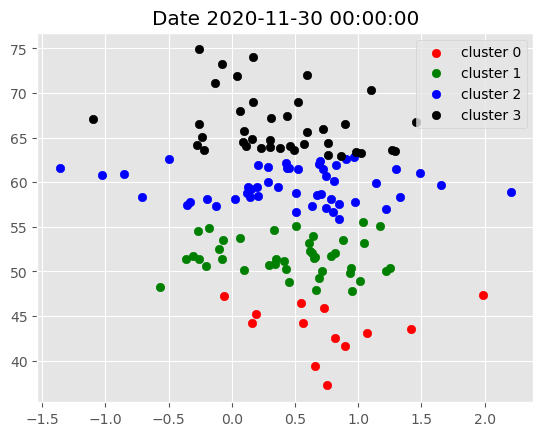

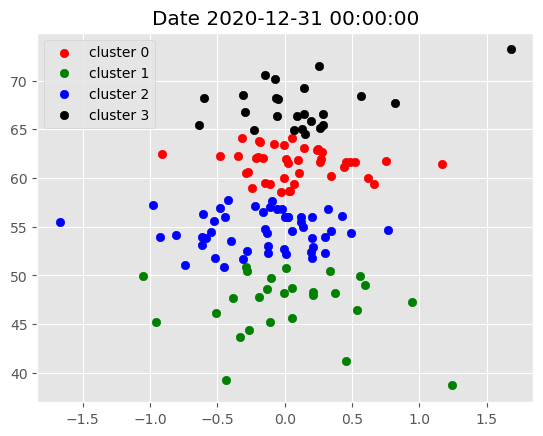

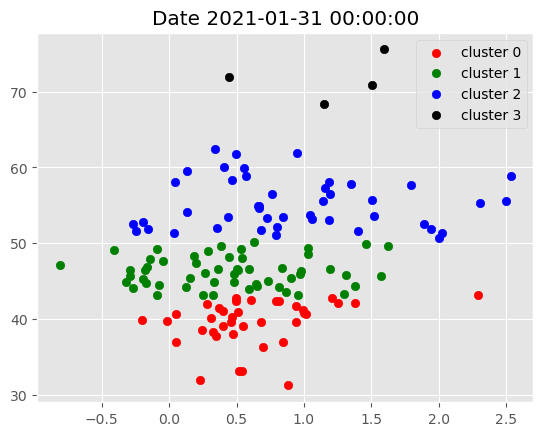

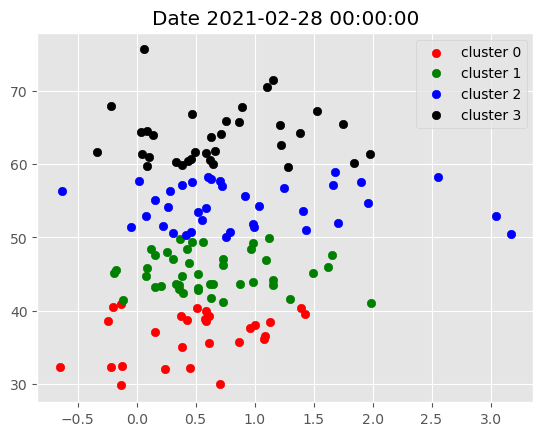

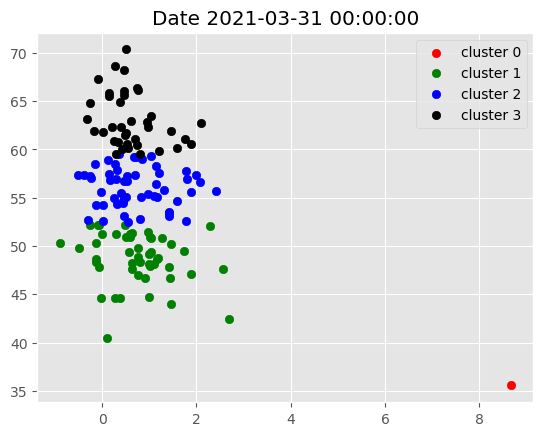

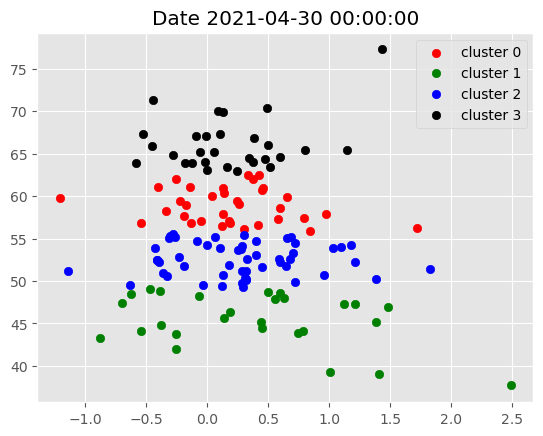

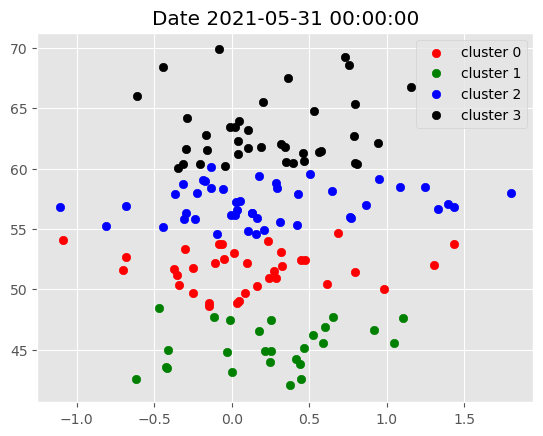

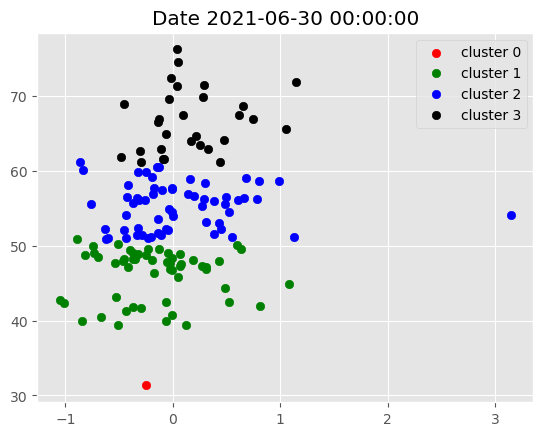

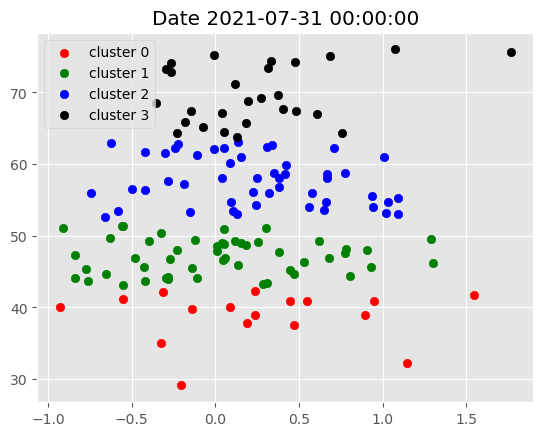

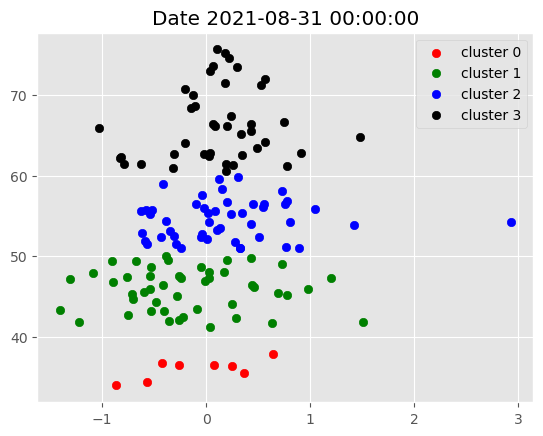

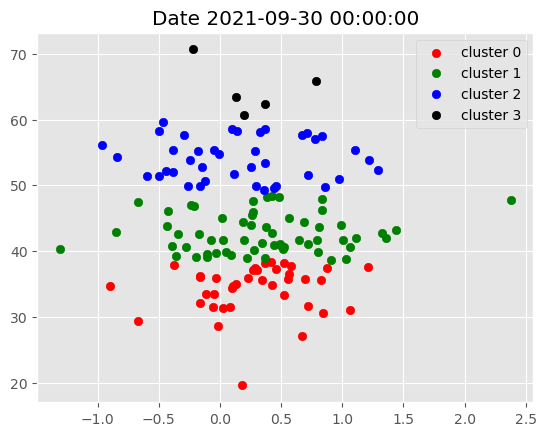

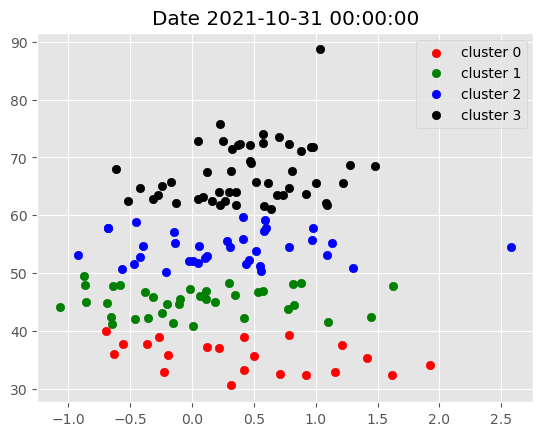

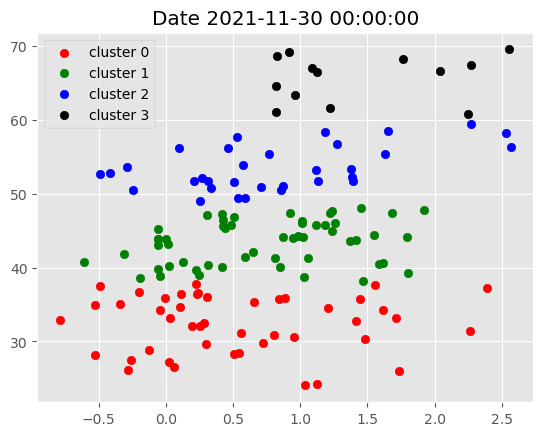

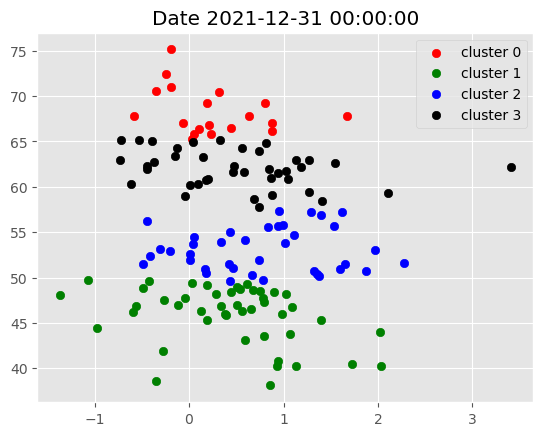

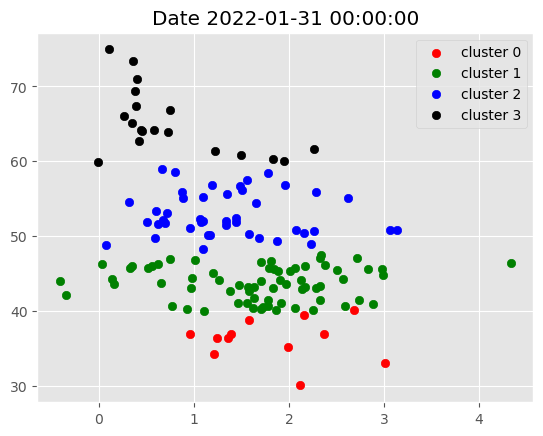

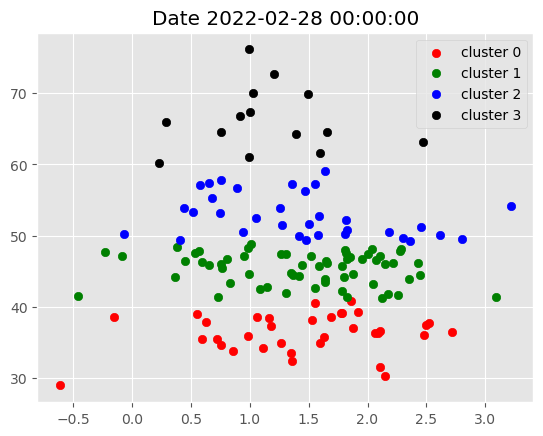

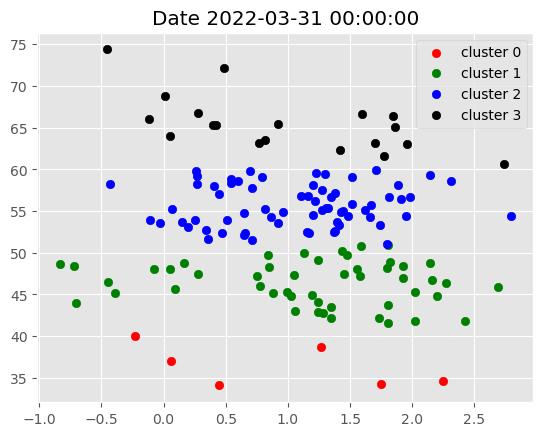

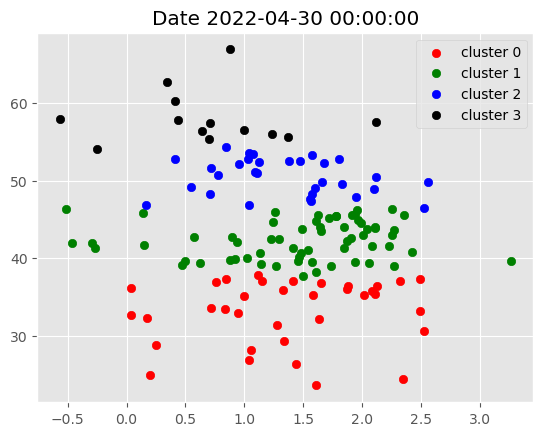

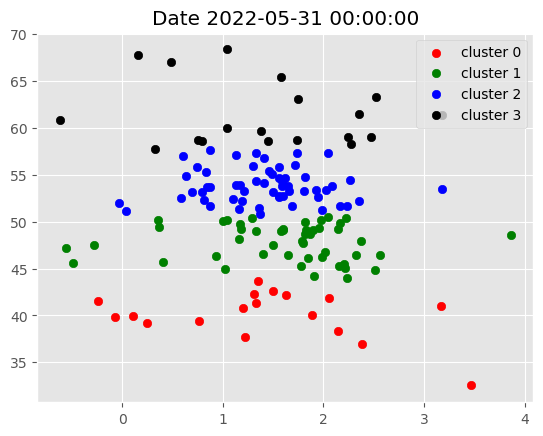

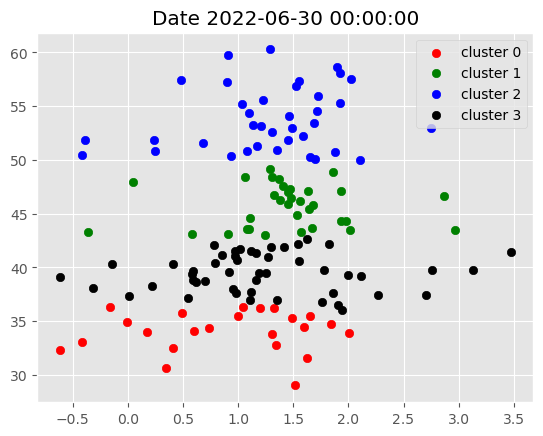

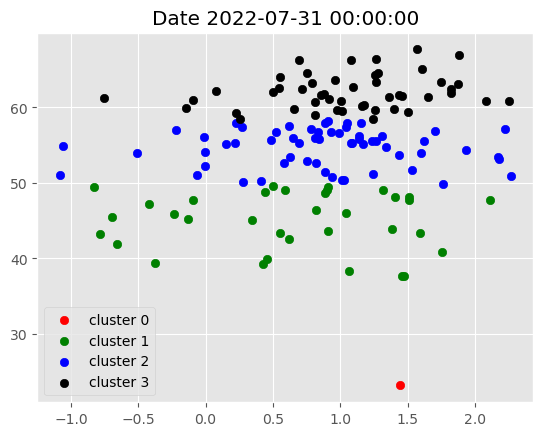

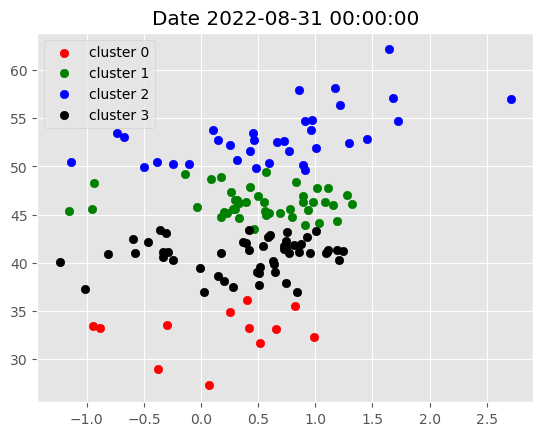

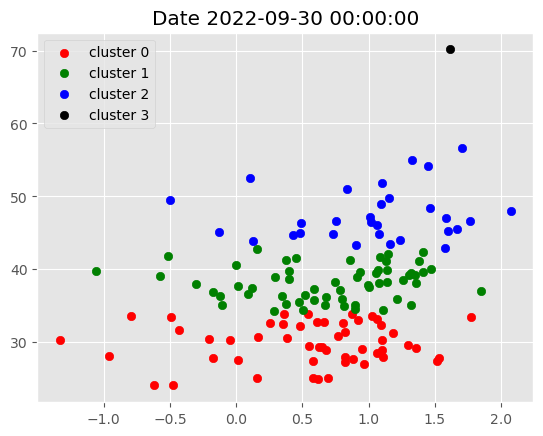

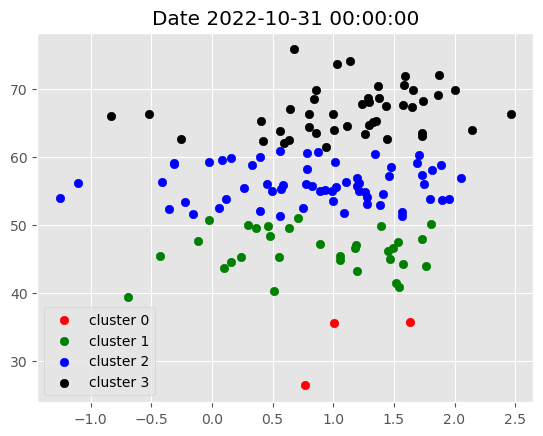

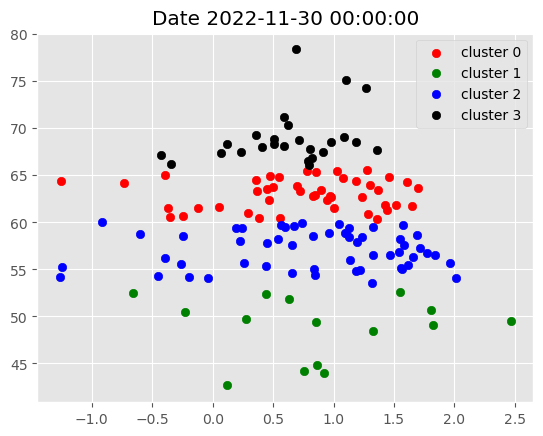

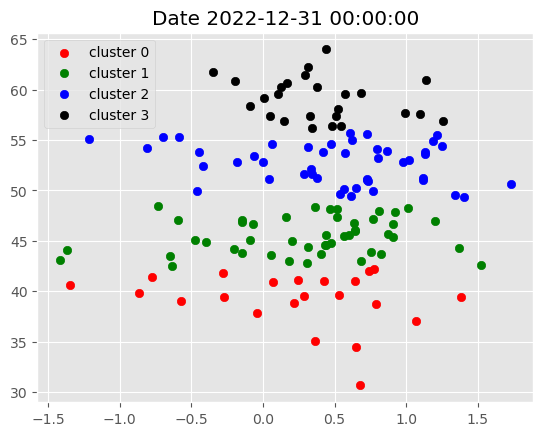

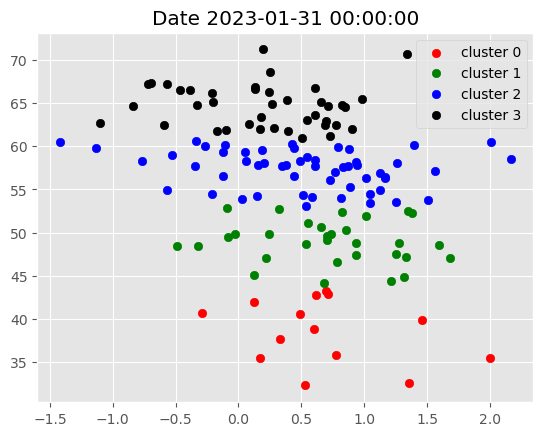

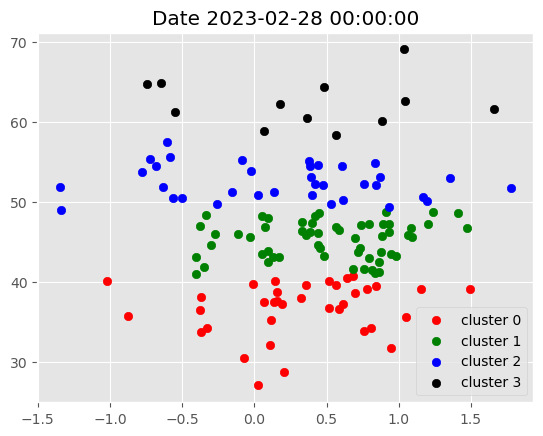

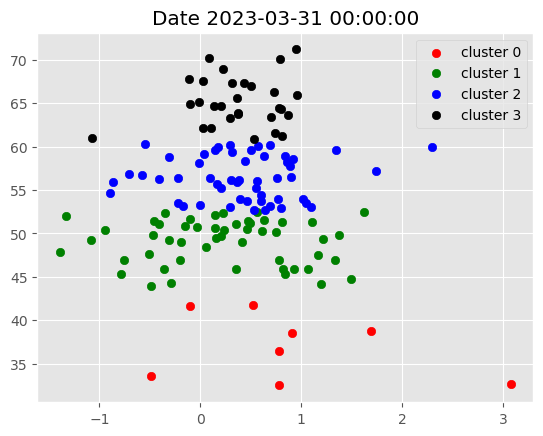

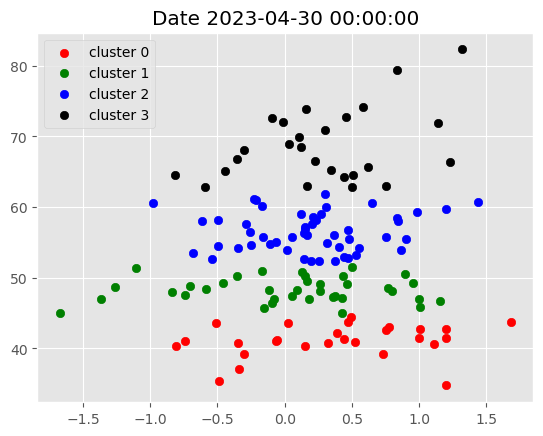

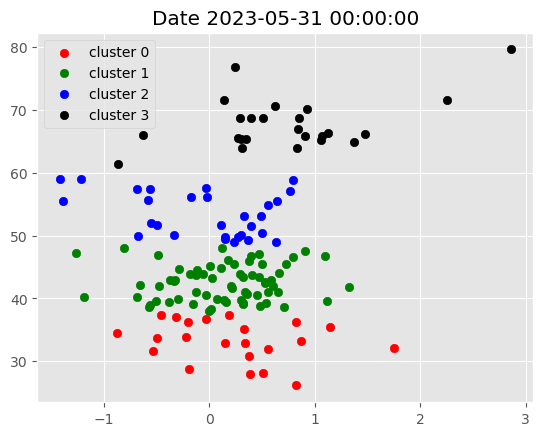

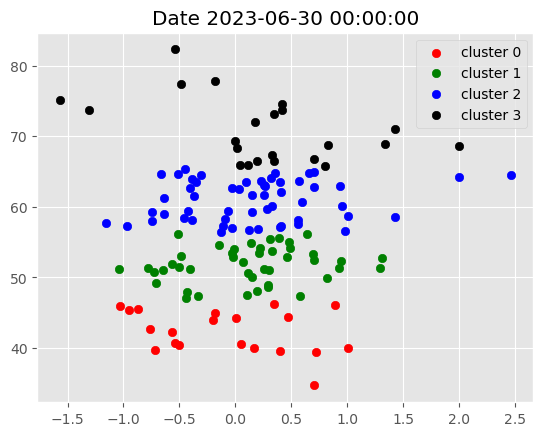

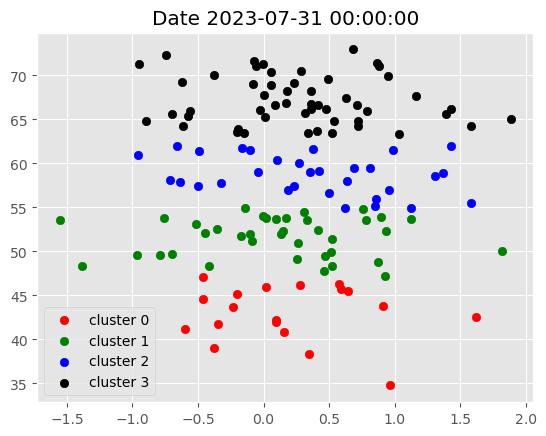

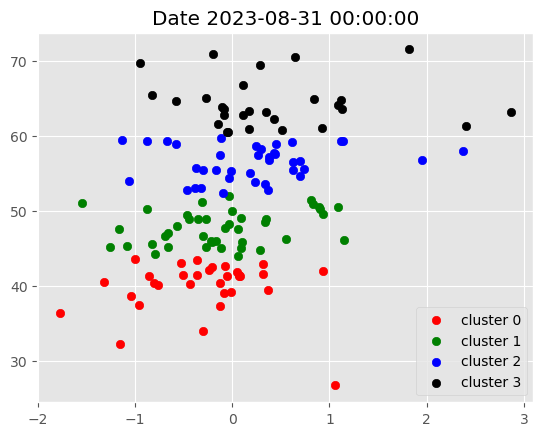

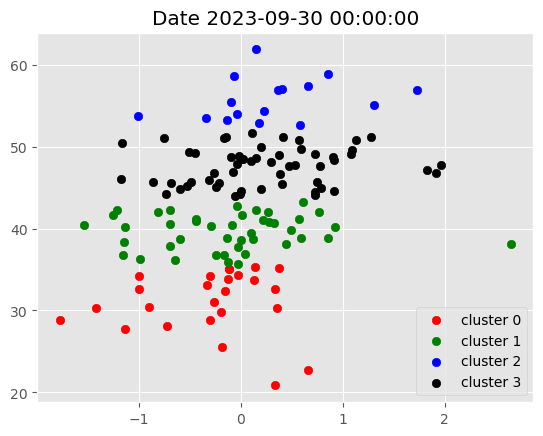

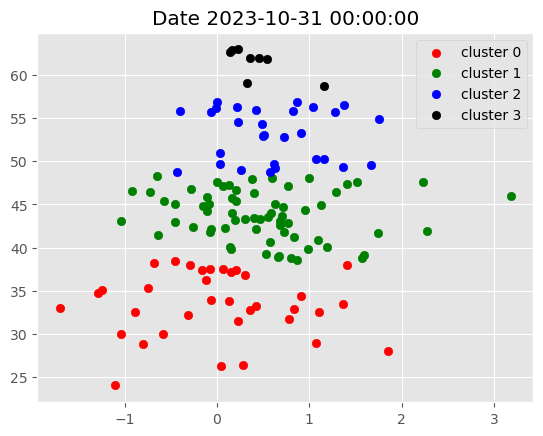

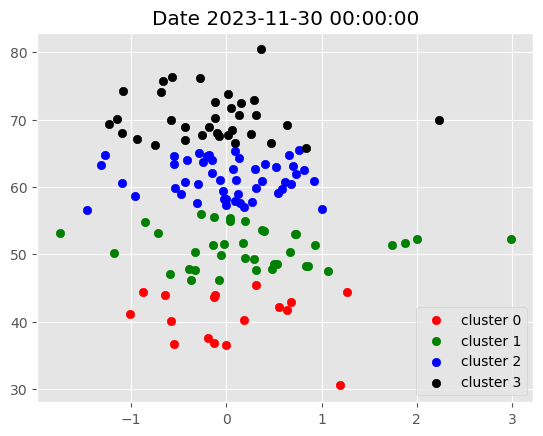

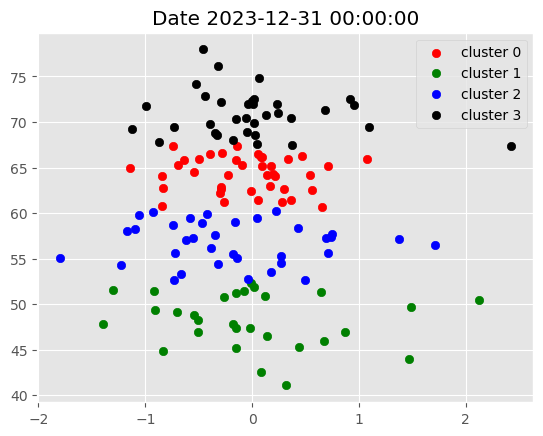

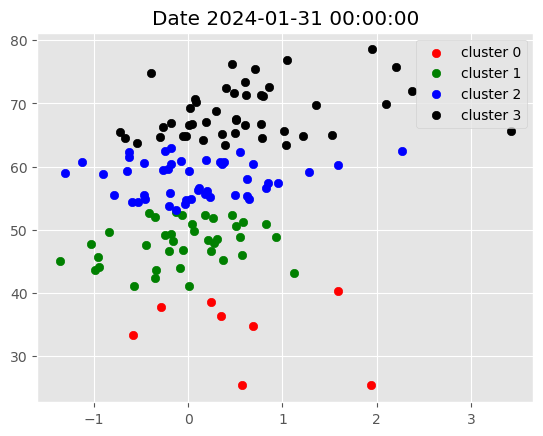

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

- Filter only stocks corresponding to the cluster we choose based on the hypothesis
- Momentum is persistent and stocks clustered around 70 RSI centroid should continue to outperform in the following month - thus would select stocks in cluster 3

In [24]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()


# a dictionary of date with all the stocks in list
fixed_dates

{'2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'C',
  'CL',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'KR',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'P

## Define portfolio optimization function

- Define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimization to maximise the sharpe ratio

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)

In [25]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices, 
                                                      frequency=252) #252 days
    
    cov = risk_models.sample_cov(prices=prices, 
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns, 
                          cov_matrix=cov, 
                          weight_bounds=(lower_bound, .1), 
                          solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

# The efficient frontier represents the set of optimal portfolios that offer the best risk-return trade-offs.

- Download Fresh Daily Prices Data only for short listed stocks

In [26]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks, 
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), 
                    end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-02-28  44.898853   32.010559   45.488468   39.848408  109.569901   
2017-03-01  45.605839   32.664852   46.216690   40.299225  110.974174   
2017-03-02  44.279018   32.470909   46.525650   40.387608  111.224625   
2017-03-03  45.344353   32.662514   46.591839   39.998669  110.589561   
2017-03-06  43.881947   32.559708   46.746304   39.892601  110.231781   
...               ...         ...         ...         ...         ...   
2024-01-22  13.620000  193.889999  165.389999  114.190002  367.209991   
2024-01-23  14.000000  195.179993  167.500000  114.000000  369.859985   
2024-01-24  13.930000  194.500000  164.220001  110.769997  368.899994   
2024-01-25  15.360000  194.169998  165.130005  112.449997  371.940002   
2024-01-26  15.130000  192.419998  164.399994  112.010002  371.070007   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-02-28  118.339996   88.560341   86.300003  53.076385   33.457169  ...   
2017-03-01  120.349998   90.208656   88.930000  53.665943   34.039112  ...   
2017-03-02  119.900002   89.811668   87.320000  53.059784   33.706577  ...   
2017-03-03  120.040001   90.182762   85.320000  53.325497   34.057598  ...   
2017-03-06  120.150002   90.571114   82.940002  52.960136   34.048363  ...   
...                ...         ...         ...        ...         ...  ...   
2024-01-22  603.590027  239.399994  250.789993  69.260002  168.300003  ...   
2024-01-23  597.179993  240.360001  252.779999  69.000000  167.050003  ...   
2024-01-24  606.479980  238.440002  252.660004  69.160004  174.139999  ...   
2024-01-25  622.580017  236.720001  251.750000  68.980003  172.630005  ...   
2024-01-26  613.929993  236.100006  253.070007  69.529999  166.899994  ...   

              Volume                                                  \
                   V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-02-28   8521900  9074700  2401900  17699200   3879900   5078100   
2017-03-01  11131400  4921900  2089400  16095600   3390500   4667800   
2017-03-02  10544200  7343000  1060900  10773400   3096800   4867100   
2017-03-03   5700600  4046600  1422600  11071600   3157600   3223100   
2017-03-06   7347600  3315300  1587700  10827300   2437500   3855000   
...              ...      ...      ...       ...       ...       ...   
2024-01-22   5984300  2903000  1411400  26039200  10663600  16473400   
2024-01-23   5883000  2883200   779800  49713700  10346800  10920900   
2024-01-24   5021700  3140800  1670900  27910400   9246400   9723800   
2024-01-25   6894900  5293300  1230600  24613200  14707700  23848700   
2024-01-26   8583300  5285000   944500  20364100  10145500  19644900   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2017-02-28  15558900  15952600  2094100  16834200  
2017-03-01  25912700  13522700  6088500  17482100  
2017-03-02  17578600   8916300  2754100  14170300  
2017-03-03  14740000   9297900  1782100  12190400  
2017-03-06  13225500   9182600  1206000   9617200  
...              ...       ...      ...       ...  
2024-01-22  19372200   4646100  2248200  19955900  
2024-01-23  16422100   4022200  1340200  15863400  
2024-01-24  17776000   7644300  2318700  17330600  
2024-01-25  17979600   5456500  2568600  22089500  
2024-01-26  19203100   5248300  1465200  20809900  

[1740 rows x 936 columns]

- Calculate daily returns for each stock which could land up in our portfolio.
- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
- Calculated each day portfolio return.

In [54]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
         # whenever optimization fails and we do not have max sharpe ratio weights, 
         # we will use equal weights for our portfolio
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-03-01,-0.012671
2018-03-02,0.010836
2018-03-05,0.017757
2018-03-06,0.006995
2018-03-07,0.002143
...,...
2024-01-22,-0.003852
2024-01-23,-0.003761
2024-01-24,0.004812


<Axes: xlabel='date'>

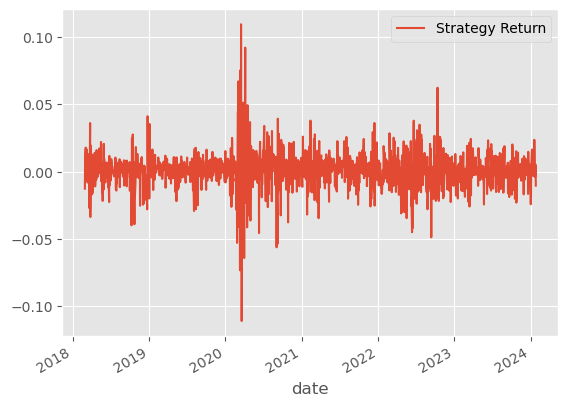

In [55]:
portfolio_df.plot()

# 8. Visualize Portfolio returns and compare to SP500 returns.

In [56]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-03-01,-0.012671,-0.014647
2018-03-02,0.010836,0.005141
2018-03-05,0.017757,0.011492
2018-03-06,0.006995,0.002531
2018-03-07,0.002143,-0.000366
...,...,...
2024-01-22,-0.003852,0.002112
2024-01-23,-0.003761,0.002912
2024-01-24,0.004812,0.001093
2024-01-25,0.005219,0.005424


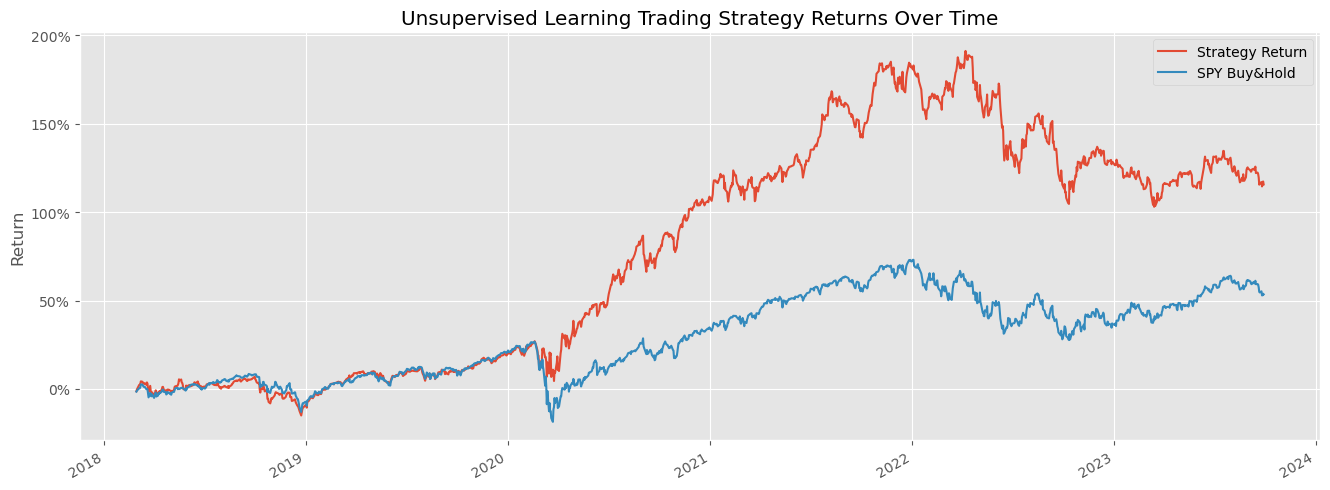

In [57]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()